In [1]:
!ls /media/inferics/DataSets/Public_Datasets/JTA-Dataset/

ls: cannot access '/media/inferics/DataSets/Public_Datasets/JTA-Dataset/': No such file or directory


In [2]:
import sys
import os

import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pyplot as plt



In [6]:
from ShAReD_Net.configure import config

config.dataset.IMG_PATH = "/dataset/jta/images_jpg"
config.dataset.ANNO_PATH = "/dataset/jta/new_image_annotations"

In [7]:
image_path = pathlib.Path(config.dataset.IMG_PATH)
ANNO_PATH = tf.constant(config.dataset.ANNO_PATH)

image_ds = tf.data.Dataset.list_files(str(image_path/'train/*/*')).shuffle(10000)

for f in image_ds.take(5):
    print(f.numpy())


b'/dataset/jta/images_jpg/train/seq_83/893.jpg'
b'/dataset/jta/images_jpg/train/seq_196/800.jpg'
b'/dataset/jta/images_jpg/train/seq_208/817.jpg'
b'/dataset/jta/images_jpg/train/seq_163/133.jpg'
b'/dataset/jta/images_jpg/train/seq_15/331.jpg'


In [8]:
def to_cam_space(joint):
    cam_transform = config.dataset.cam_transform
    joint_homog = tf.linalg.matvec(cam_transform, joint)
    cam_space_joint = joint_homog / joint_homog[2]
    return cam_space_joint

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(len(image_batch)):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        poses = label_batch[n]
        for pose in poses:
            for joint in pose:
                text = f"[{joint[0]},{joint[1]}]"
                print(text)
                cam_space_joint = to_cam_space(joint)
                plt.text(cam_space_joint[0],cam_space_joint[1], text)
        plt.axis('off')

def get_annotation_path(img_path):
    # convert the path to a list of path components
    parts = tf.strings.split(img_path, os.path.sep)
    data_split = parts[-3]
    seq = parts[-2]
    img_name = parts[-1]

    anno_name = tf.strings.split(img_name, '.')[0] + '.npy'
    anno_path = tf.strings.join([ANNO_PATH,data_split,seq,anno_name], separator='/')
    # The second to last is the class-directory
    return anno_path

def get_annotation(anno_path):
    poses = np.load(anno_path, allow_pickle=True)
    annos = np.empty([len(poses),15,3], dtype=np.float32)
    for i, pose in enumerate(poses):
        annos[i,0,0] = pose[1].x3d
        annos[i,0,1] = pose[1].y3d
        annos[i,0,2] = pose[1].z3d

        annos[i,1,0] = pose[2].x3d
        annos[i,1,1] = pose[2].y3d
        annos[i,1,2] = pose[2].z3d

        annos[i,2,0] = pose[15].x3d
        annos[i,2,1] = pose[15].y3d
        annos[i,2,2] = pose[15].z3d

        annos[i,3,0] = pose[4].x3d
        annos[i,3,1] = pose[4].y3d
        annos[i,3,2] = pose[4].z3d

        annos[i,4,0] = pose[8].x3d
        annos[i,4,1] = pose[8].y3d
        annos[i,4,2] = pose[8].z3d

        annos[i,5,0] = pose[5].x3d
        annos[i,5,1] = pose[5].y3d
        annos[i,5,2] = pose[5].z3d

        annos[i,6,0] = pose[9].x3d
        annos[i,6,1] = pose[9].y3d
        annos[i,6,2] = pose[9].z3d

        annos[i,7,0] = pose[6].x3d
        annos[i,7,1] = pose[6].y3d
        annos[i,7,2] = pose[6].z3d

        annos[i,8,0] = pose[10].x3d
        annos[i,8,1] = pose[10].y3d
        annos[i,8,2] = pose[10].z3d

        annos[i,9,0] = pose[16].x3d
        annos[i,9,1] = pose[16].y3d
        annos[i,9,2] = pose[16].z3d

        annos[i,10,0] = pose[19].x3d
        annos[i,10,1] = pose[19].y3d
        annos[i,10,2] = pose[19].z3d

        annos[i,11,0] = pose[17].x3d
        annos[i,11,1] = pose[17].y3d
        annos[i,11,2] = pose[17].z3d

        annos[i,12,0] = pose[20].x3d
        annos[i,12,1] = pose[20].y3d
        annos[i,12,2] = pose[20].z3d

        annos[i,13,0] = pose[18].x3d
        annos[i,13,1] = pose[18].y3d
        annos[i,13,2] = pose[18].z3d

        annos[i,14,0] = pose[21].x3d
        annos[i,14,1] = pose[21].y3d
        annos[i,14,2] = pose[21].z3d

    return annos

def process_path(file_path):
    anno_path = get_annotation_path(file_path)
    anno = tf.numpy_function(get_annotation, [anno_path], tf.float32)
    anno.set_shape([None,15,3])

    return file_path, anno


In [9]:
import ShAReD_Net.data.load.dataset_jta.joint as joint
import ShAReD_Net.data.load.dataset_jta.pose as pose
sys.modules['joint'] = joint
sys.modules['pose'] = pose

In [11]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = image_ds.map(process_path,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [12]:
def person_pos_from_pose(path, poses):
    poss = tf.reduce_mean(poses, axis=-2)
    return path, poss, poses

In [13]:
pos_pose_ds = labeled_ds.map(person_pos_from_pose)

In [14]:
#@tf.function
def poss_and_poses_to_img(path, poss, poses):
    poss_img = poss_to_img(poss)
    poses_img = poses_to_img(poses)

    return path, poss_img, poses_img

def poss_to_img(poss):
    cam_transform = config.dataset.cam_transform
    poss_homog = tf.linalg.matvec(cam_transform, poss)
    poss_img = poss_homog / poss_homog[:,None,-1]
    return tf.concat([poss_img[:,:-1],poss[:,None,-1]], axis=-1)

def poses_to_img(poses):
    cam_transform = config.dataset.cam_transform
    poses_homog = tf.linalg.matvec(cam_transform, poses)
    poses_img = poses_homog / poses_homog[:,:,None,-1]
    return tf.concat([poses_img[:,:,:-1],poses[:,:,None,-1]], axis=-1)


In [15]:
cam_ds = pos_pose_ds.map(poss_and_poses_to_img)

In [16]:

def poss_and_poses_to_cut(cut_dist, dist_delta, upscaling, cam_intr_f):
    def to_cut(img, poss, poses):
        poss_cut = poss_to_cut(poss, cut_dist, upscaling, cam_intr_f)
        poses_cut = poses_to_cut(poses, cut_dist, upscaling, cam_intr_f)
        poss_cut_filtered, poses_cut_filtered = filter_poss_and_pose(poss_cut, poses_cut, cut_dist, dist_delta)
        return img, poss_cut_filtered, poses_cut_filtered
    return to_cut

def poss_to_cut(poss, dist, upscaling, cam_intr_f):
    poss_cut = poss * upscaling * dist / cam_intr_f
    return tf.concat([poss_cut[:,:-1],poss[:,None,-1]], axis=-1)

def poses_to_cut(poses, dist, upscaling, cam_intr_f):
    poses_cut = poses * upscaling * dist / cam_intr_f
    return tf.concat([poses_cut[:,:,:-1],poses[:,:,None,-1]], axis=-1)

def filter_poss_and_pose(poss, poses, dist, dist_delta):
    indexes = tf.where(tf.abs(poss[:,-1]-dist) < dist_delta)
    filtered_poss = tf.gather_nd(poss, indexes)
    filtered_poses = tf.gather_nd(poses, indexes)

    return filtered_poss, filtered_poses



In [17]:
cut_ds = cam_ds.map(poss_and_poses_to_cut(cut_dist=15, dist_delta=config.model.data.cut_delta, upscaling=config.model.data.upscaling, cam_intr_f = config.dataset.cam_intr_f))


In [18]:
#TODO TEST VALIDATION to singel item datasets
def to_rel_poses(path, poss, poses):
    return poses-poss[:,None,:]

poses_ds = cut_ds.map(to_rel_poses)
poses_ds = poses_ds.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))

In [19]:
import tensorflow_datasets as tfds
import pandas as pd


In [40]:
def to_keypoints(pose):
    return tf.sqrt(pose[:,0]**2 + pose[:,1]**2)

In [41]:
keypoint_ds = poses_ds.map(to_keypoints).take(3000)


In [44]:
numpy_data = tfds.as_numpy(keypoint_ds)
keypoint_df = pd.DataFrame(data=numpy_data)

(array([15.,  0.,  3.,  1.,  4.,  3.,  3.,  2.,  3.,  1.,  3.,  2.,  1.,
         0.,  1.,  0.,  1.,  1.,  0.,  1.]),
 array([  0.42266655,   5.55055628,  10.67844601,  15.80633574,
         20.93422546,  26.06211519,  31.19000492,  36.31789465,
         41.44578438,  46.57367411,  51.70156384,  56.82945356,
         61.95734329,  67.08523302,  72.21312275,  77.34101248,
         82.46890221,  87.59679193,  92.72468166,  97.85257139,
        102.98046112]),
 <a list of 20 Patch objects>)

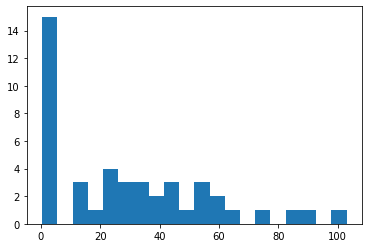

In [47]:
person_size_df = keypoint_df.max(1)
plt.hist(inter_person_size_df, 20)

In [24]:
person_size_df = keypoint_df.T.max() - keypoint_df.T.min()

In [26]:
keypoint_df.shape

(3000, 45)

114.42589950561523
62.550018310546875


(array([  2.,   0.,  10.,   8.,   3.,   4.,   8.,  40., 115., 287., 370.,
        426., 404., 345., 324., 279., 236.,  98.,  32.,   9.]),
 array([ 62.55001831,  65.14381237,  67.73760643,  70.33140049,
         72.92519455,  75.51898861,  78.11278267,  80.70657673,
         83.30037079,  85.89416485,  88.48795891,  91.08175297,
         93.67554703,  96.26934109,  98.86313515, 101.45692921,
        104.05072327, 106.64451733, 109.23831139, 111.83210545,
        114.42589951]),
 <a list of 20 Patch objects>)

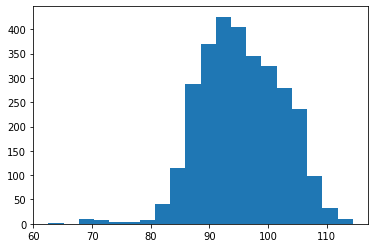

In [25]:
print(person_size_df.max())
print(person_size_df.min())

plt.hist(person_size_df, 20)


### upscaling = 32 -> mean_person_size = 42, max_person_size = 60, min_person_size = 37 -> 11/15/10 ROI
### upscaling = 36 -> mean_person_size = 47, max_person_size = 67, min_person_size = 42 -> 12/17/11 ROI
### upscaling = 50 -> mean_person_size = 67, max_person_size = 95, min_person_size = 60 -> 17/24/15 ROI